In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

bike_df = pd.read_csv('/content/sample_data/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
bike_df['datetime']=bike_df['datetime'].apply(pd.to_datetime)

bike_df['year']=bike_df['datetime'].apply(lambda x:x.year)
bike_df['month']=bike_df['datetime'].apply(lambda x:x.month)
bike_df['day']=bike_df['datetime'].apply(lambda x:x.day)
bike_df['hour']=bike_df['datetime'].apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [6]:
drop_cols=['datetime','casual','registered']
bike_df.drop(drop_cols,axis=1,inplace=True)

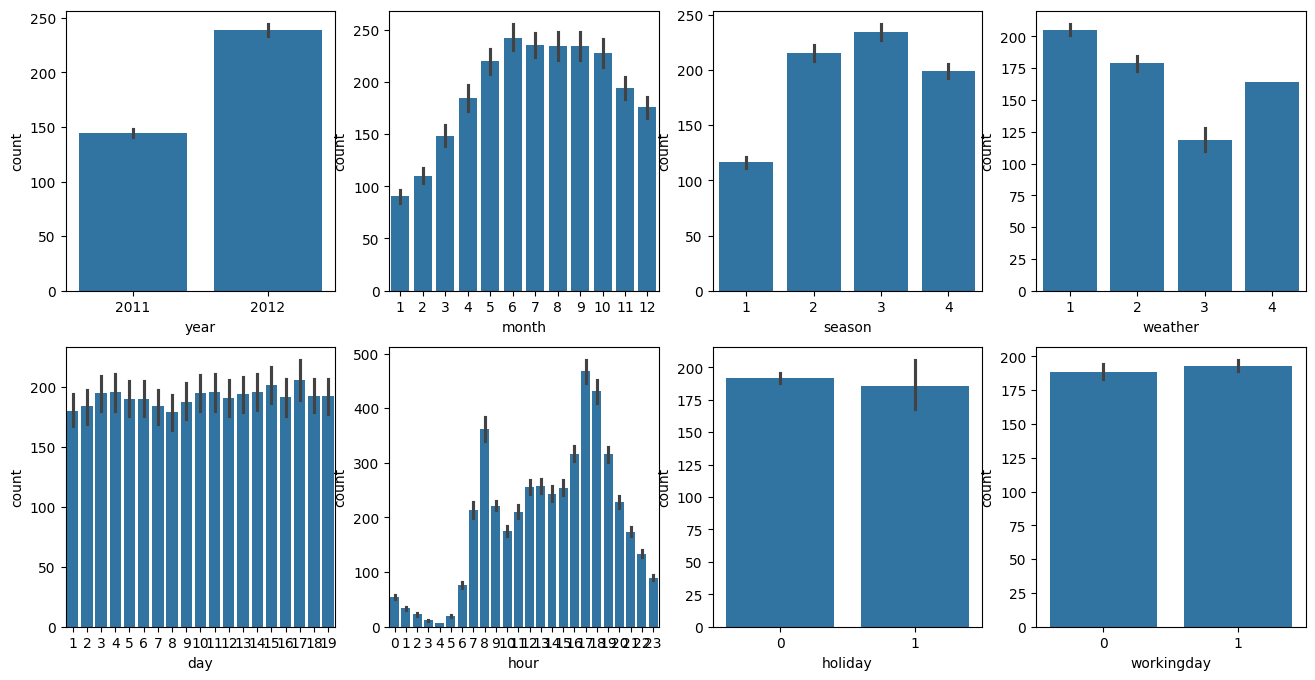

In [7]:
fig,axs = plt.subplots(figsize=(16,8), ncols= 4, nrows= 2)
cat_features = ['year',  'month','season','weather','day',  'hour',  'holiday','workingday']

for i,feature in enumerate(cat_features):
  row = int(i/4)
  col =i%4
  sns.barplot(x=feature,y='count',data=bike_df,ax=axs[row][col])

In [8]:
#사이킷 런에서는 RMSLE 를 제공하지 않아 성능평가 함수를 직접 제작
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y-log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)

  mae_val = mean_absolute_error(y,pred)
  print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


In [10]:
def get_top_error_data(y_test,pred,n_tops=5):
  result_df = pd.DataFrame(y_test.values,columns=['real_count'])
  result_df['predicted_count'] = np.round(pred,0)
  result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
  print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

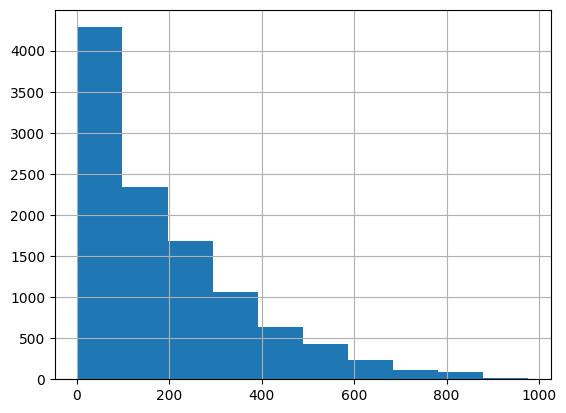

In [11]:
y_target.hist()

<Axes: >

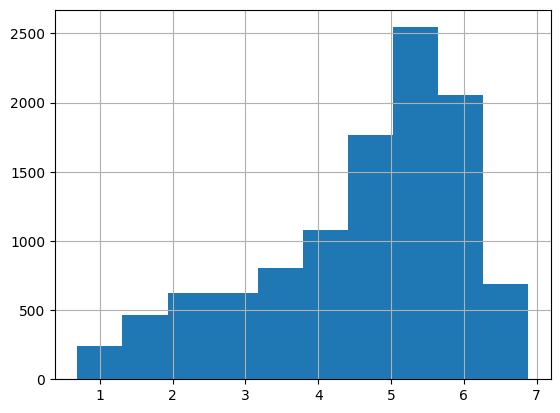

In [12]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [13]:
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,test_size=0.3,random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#   테스트    데이터     세트의    Target 값은    로그    변환됐으므로    다시     expml을     이용해     원래     스케일로    변환
y_test_exp = np.expm1(y_test)


In [14]:
pred_exp = np.expm1(pred)
evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


<Axes: ylabel='None'>

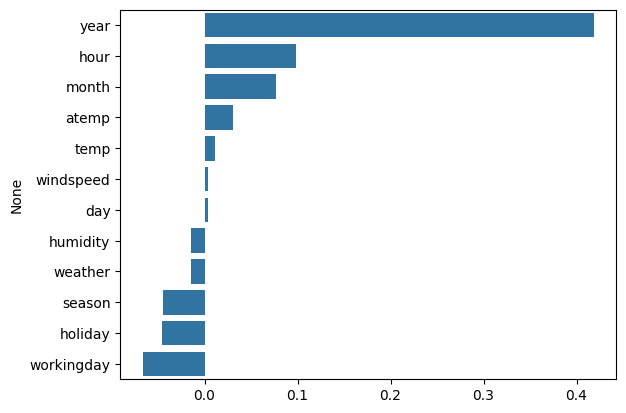

In [15]:
coef = pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [16]:
X_features_ohe = pd.get_dummies(X_features,columns=['year','month','season','weather','day','hour','holiday','workingday'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
test_size=0.3, random_state=0)

def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###',model.__class__.__name__,'###')
  evaluate_regr(y_test,pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
  get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


<Axes: ylabel='None'>

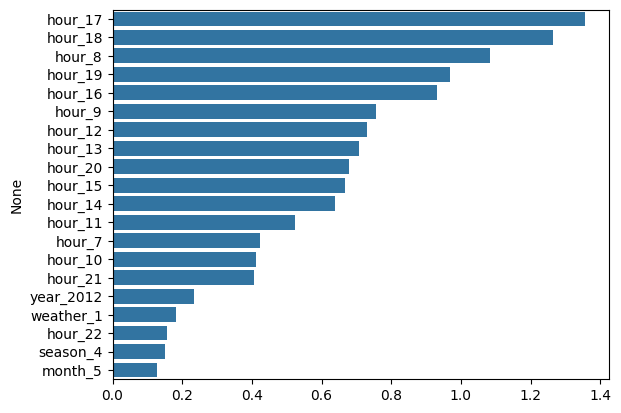

In [18]:
coef = pd.Series(lr_reg.coef_,index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [19]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gdm_reg = GradientBoostingRegressor(n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg,gdm_reg,xgb_reg,lgbm_reg]:
  get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.355, RMSE : 50.538, MAE : 31.240
### GradientBoostingRegressor ###
RMSLE : 0.321, RMSE : 50.673, MAE : 31.037
### XGBRegressor ###
RMSLE : 0.339, RMSE : 51.473, MAE : 31.360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/sample_data/house_price.csv')
house_df = house_df_org
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [21]:
print('데이터 세트의 shape:',house_df.shape)
print('\n전체 피처의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 값이 있는 피처의 type \n',isnull_series[isnull_series>0].sort_values(ascending=False))


데이터 세트의 shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 값이 있는 피처의 type 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

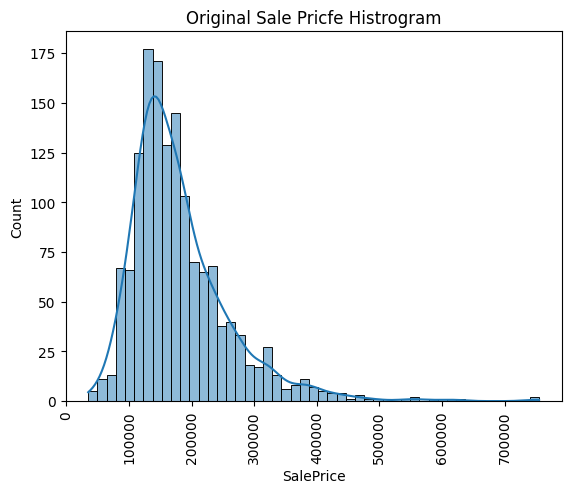

In [22]:
plt.title('Original Sale Pricfe Histrogram')
plt.xticks(rotation='vertical')
sns.histplot(house_df['SalePrice'],kde = True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

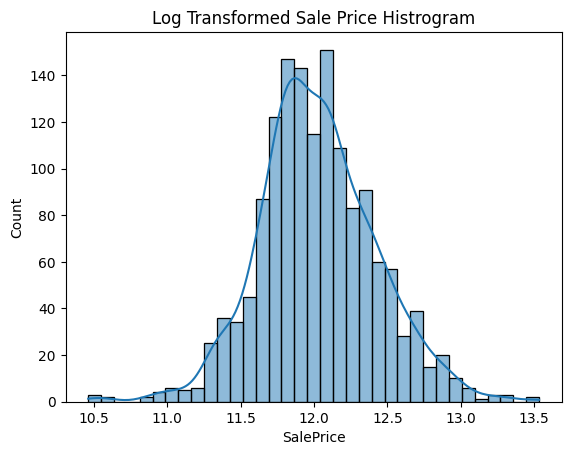

In [23]:
plt.title('Log Transformed Sale Price Histrogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(np.log1p(house_df['SalePrice']),kde = True)
plt.show

In [24]:
#로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])
# house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis = 1, inplace = True) # These columns were already dropped

# Fill missing values with the mean of numeric columns
numeric_cols = house_df.select_dtypes(include=np.number).columns
house_df[numeric_cols] = house_df[numeric_cols].fillna(house_df[numeric_cols].mean())

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('##Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

##Null 피처의 Type:
 Alley           object
MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
FireplaceQu     object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
PoolQC          object
Fence           object
MiscFeature     object
dtype: object


In [25]:
print('get_dummies() 수행전 데이터 Shape:',house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행후 데이터 Shape:',house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('##Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행전 데이터 Shape: (1460, 81)
get_dummies() 수행후 데이터 Shape: (1460, 289)
##Null 피처의 Type:
 Series([], dtype: object)


In [26]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse  = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print (model.__class__.__name__,'로그 변환된RMSE：',np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses = [ ]
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses #여러 모델의 RMSE 값을 반환하는 것




In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
random_state=156)

#    LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train,  y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train,  y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된RMSE： 0.133
Ridge 로그 변환된RMSE： 0.13
Lasso 로그 변환된RMSE： 0.177


[np.float64(0.13257601792662113),
 np.float64(0.13000240336806282),
 np.float64(0.17688509722693235)]

In [28]:
def get_top_bottom_coef(model,n=10):
  coef = pd.Series(model.coef_,index=X_features.columns)
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high,coef_low

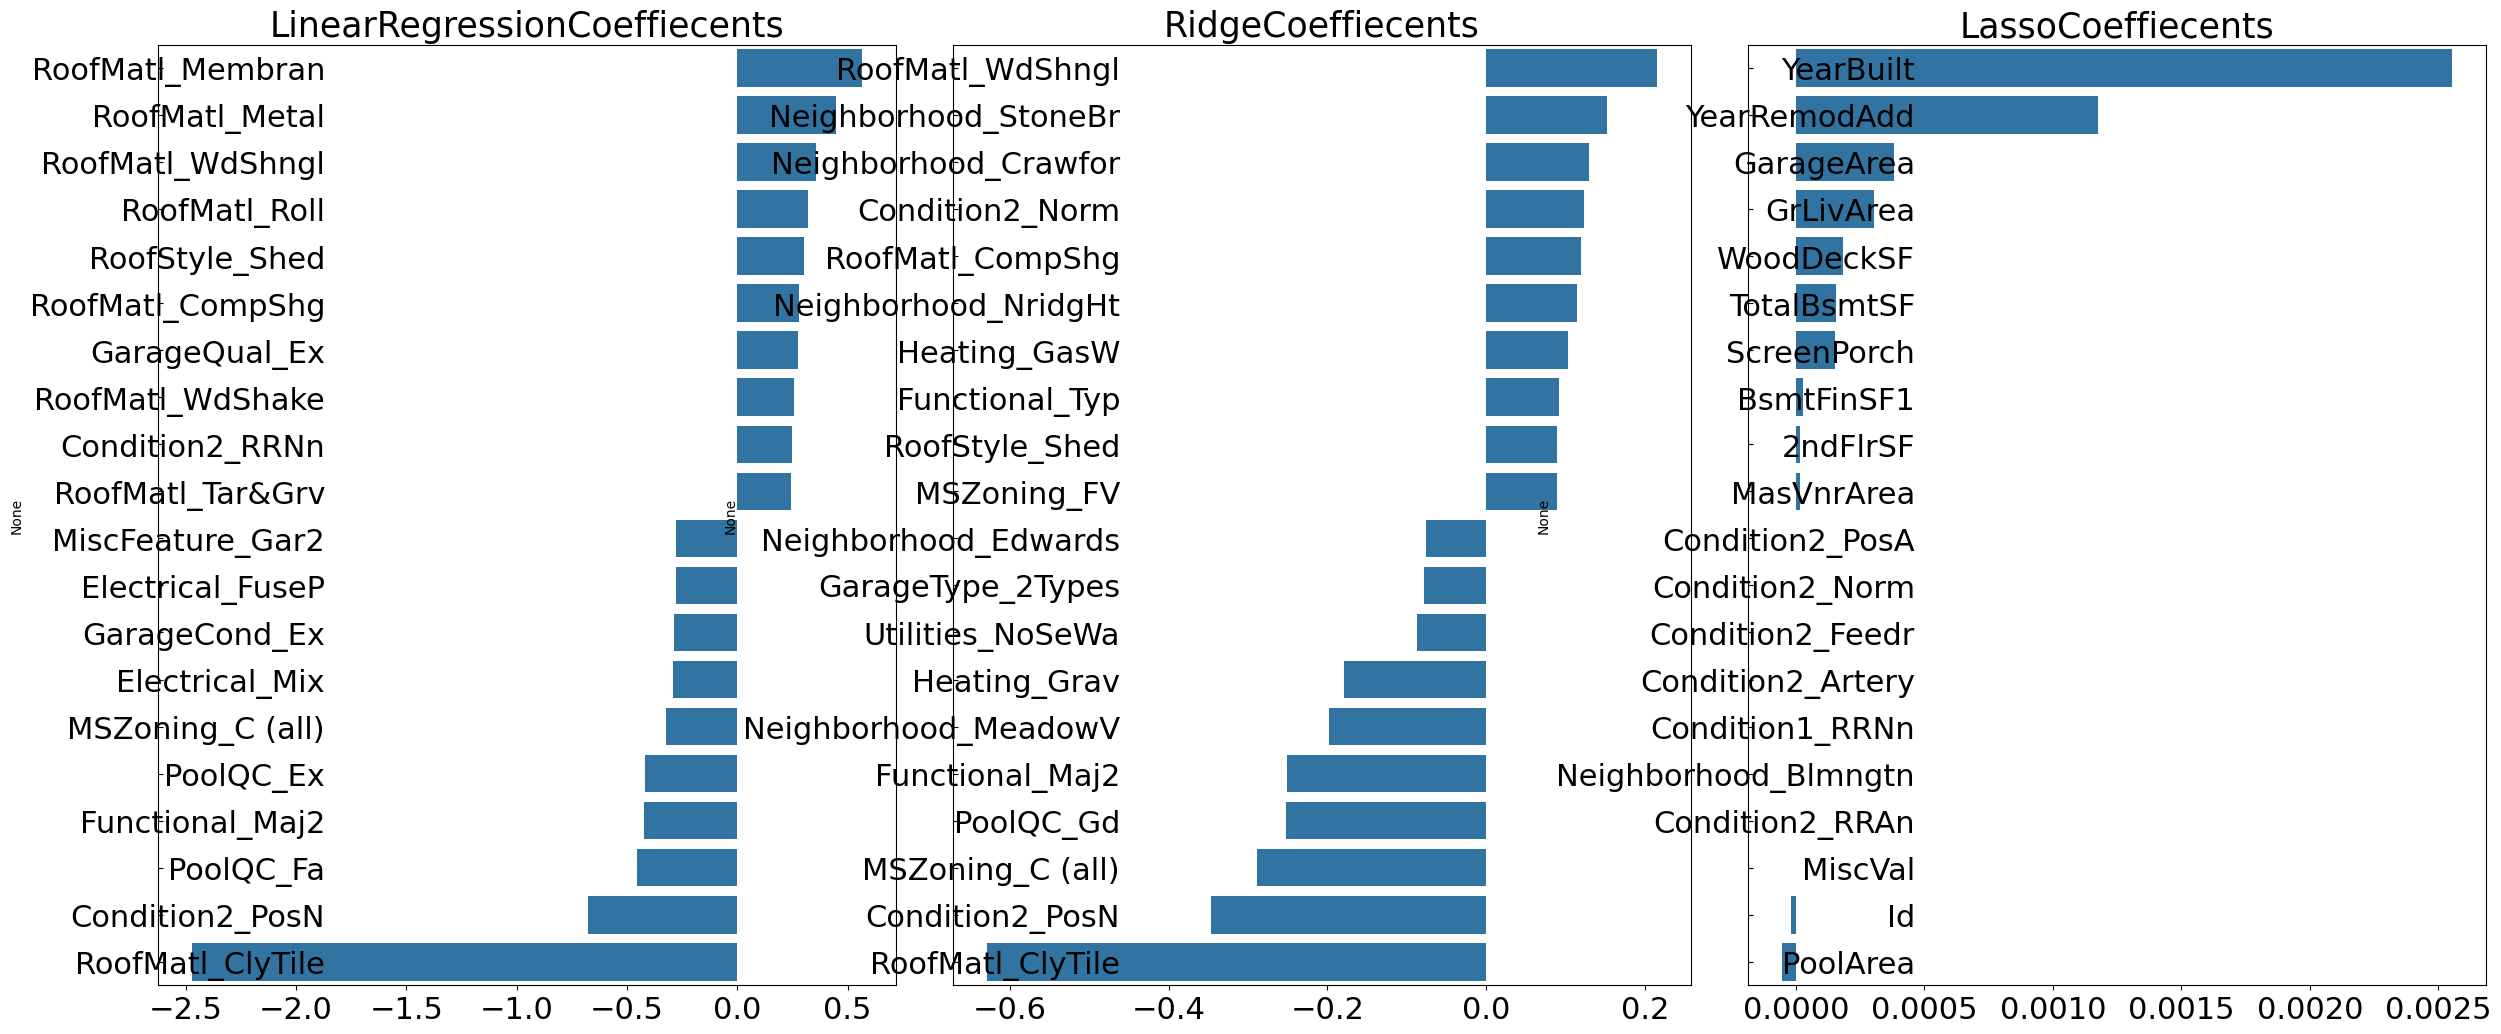

In [29]:
def visualize_coefficient(models):
  fig, axs = plt.subplots(figsize=(24, 10), nrows=1,  ncols=3)
  fig.tight_layout()
#    입력     인자로    받은    list 객체인    models에서     차례로   model을    추출해    회귀     계수    시각화.
  for i_num, model  in enumerate(models):
#    상위     10개, 하위     10개     회귀     계수를    구하고,  이를    판다스    concat으로    결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat(   [coef_high, coef_low]  )
#    ax subplot에     barchar로    표현. 한    화면에    표현하기    위해    tick label 위치와   font 크기     조정.
    axs[i_num].set_title(model.__class__.__name__ +'Coeffiecents', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
        label.set_fontsize(22)
    sns.barplot(x=coef_concat.values,  y=coef_concat.index,  ax=axs[i_num])
#  앞    예제에서     학습한    lr_reg, ridge_reg, lasso_reg 모델의    회귀     계수    시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [32]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    rmse_list =np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv = 5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} 5 CV RMSE 값 리스트:{1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} 5 CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge 5 CV RMSE 값 리스트:[0.121 0.154 0.143 0.117 0.189]
Ridge 5 CV 평균 RMSE 값: 0.145

Lasso 5 CV RMSE 값 리스트:[0.161 0.204 0.177 0.181 0.265]
Lasso 5 CV 평균 RMSE 값: 0.198


In [59]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params,
  scoring='neg_mean_squared_error',  cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)

  best_param_name = None
  if isinstance(model, (Ridge, Lasso)):
      best_param_name = 'alpha'
  elif isinstance(model, XGBRegressor):
      best_param_name = 'n_estimators' # Assuming n_estimators is the key in params for XGBoost

  if best_param_name and best_param_name in grid_model.best_params_:
    print('{0} 5 CV 시 평균 RMSE 값: {1}, 최적 {2} {3}'.format(model.__class__.__name__, np.round(rmse, 3), best_param_name, grid_model.best_params_[best_param_name]))
  else:
      print('{0} 5 CV 시 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse, 3)))
      print('최적 파라미터:', grid_model.best_params_)


ridge_params = {   'alpha':[0.05, 0.1, 1,  5, 8,  10,  12,  15, 20]  }
lasso_params = {   'alpha':[0.001,  0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,  5,  10]  }
print_best_params(ridge_reg,  ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 평균 RMSE 값: 0.139, 최적 alpha 1
Lasso 5 CV 시 평균 RMSE 값: 0.139, 최적 alpha 0.001


LinearRegression 로그 변환된RMSE： 0.133
Ridge 로그 변환된RMSE： 0.125
Lasso 로그 변환된RMSE： 0.121


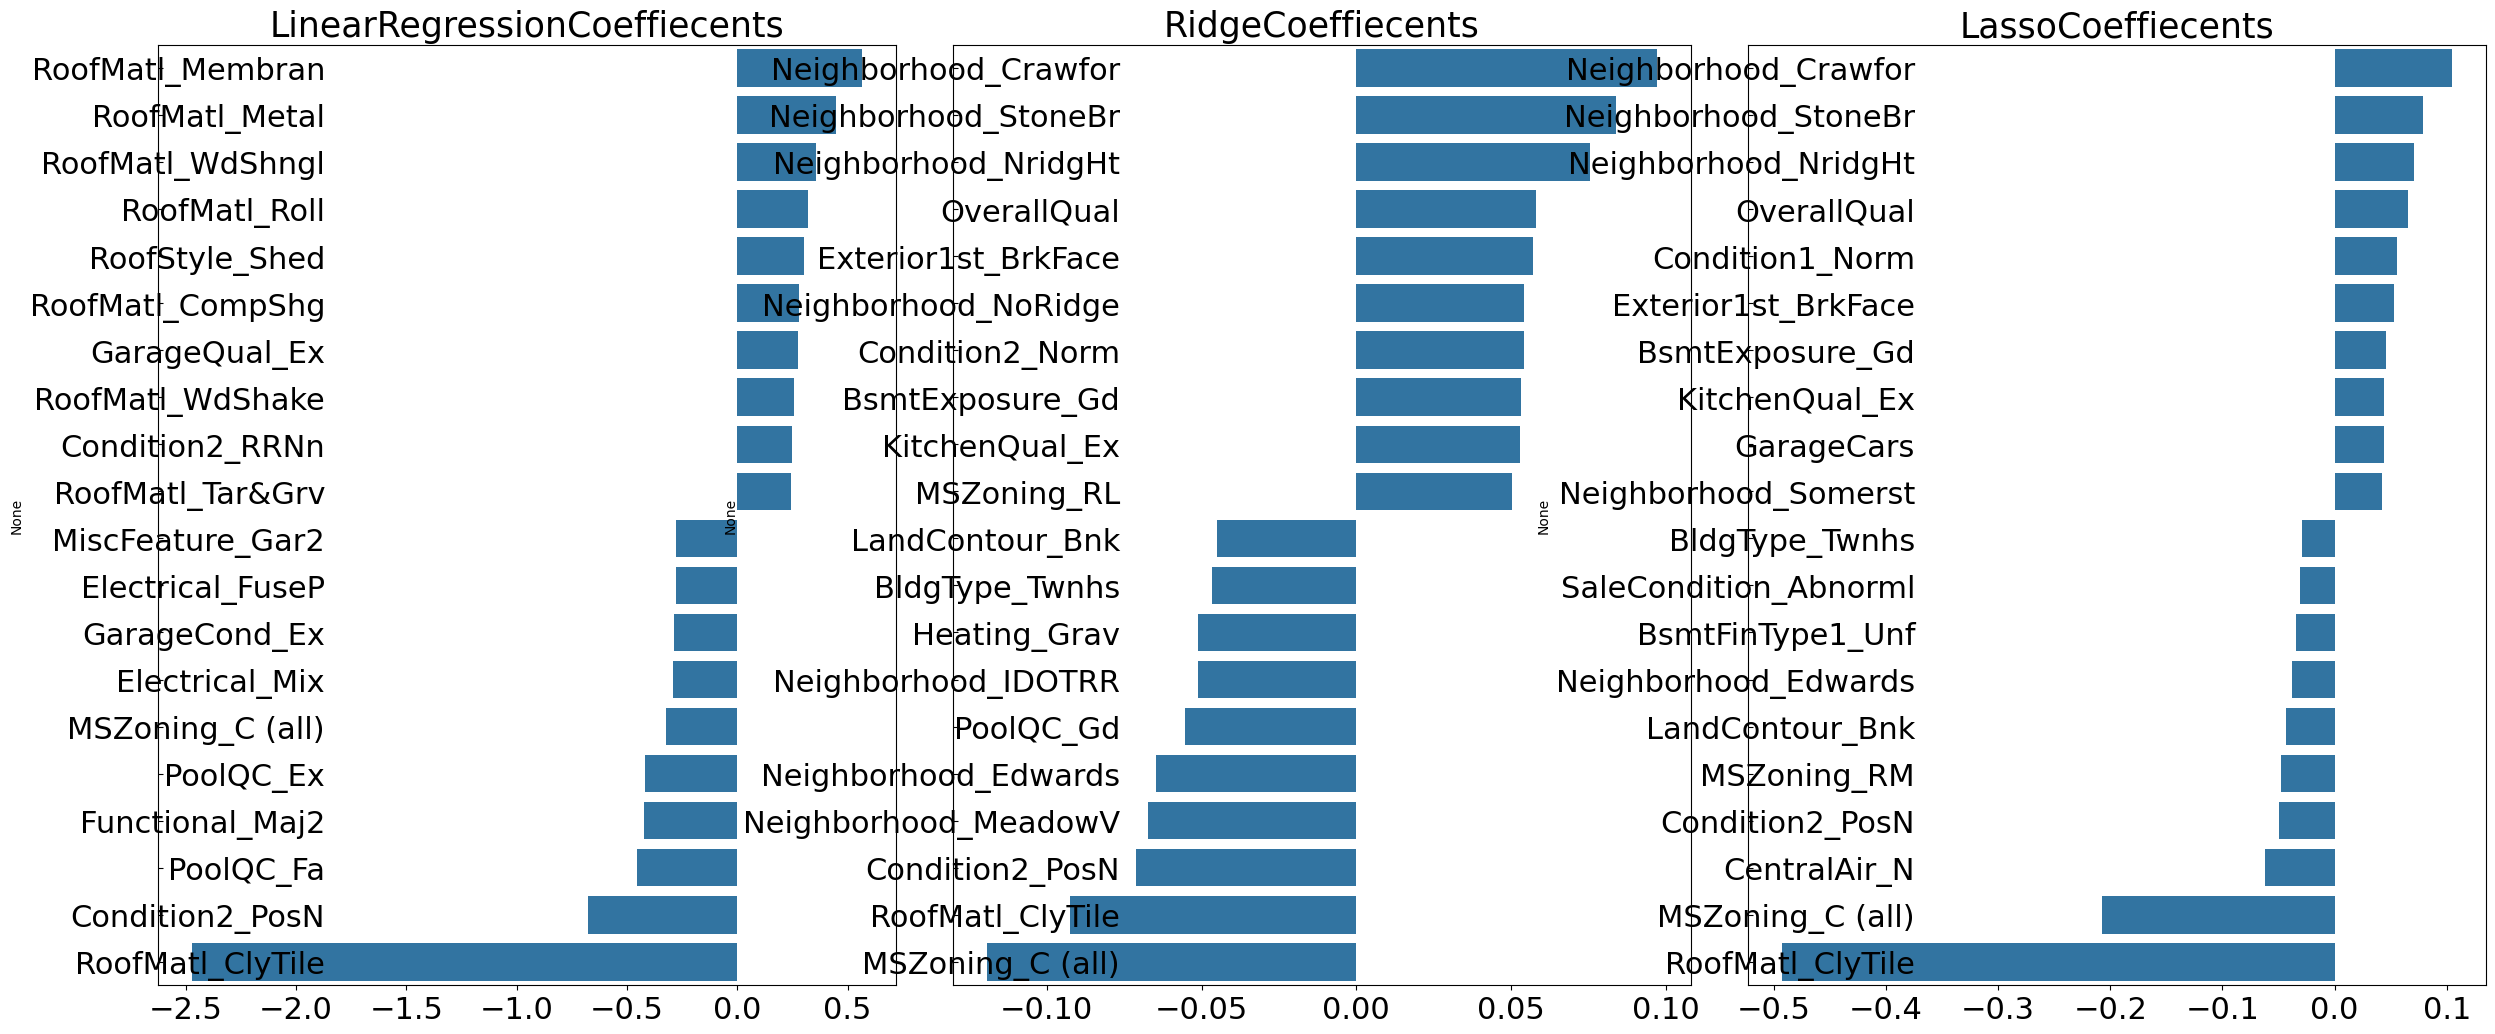

In [37]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,  y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
#    모든    모델의     RMSE  출력
models = [lr_reg,ridge_reg, lasso_reg]
get_rmses(models)
#    모든    모델의     회귀     계수    시각화
models = [lr_reg,ridge_reg, lasso_reg]
visualize_coefficient(models)

In [38]:
from scipy.stats import skew
#   object가    아닌    숫자형    피처의     칼럼     index 객체    추출.
features_index = house_df.dtypes[house_df.dtypes  != 'object'].index
#   house_df에      칼럼     index를     [    ]로     입력하면     해당하는    칼럼      데이터     세트     반환. apply lambda로    skew(  )  호출
skew_features = house_df[features_index].apply(lambda x :   skew(x))
#   skew(왜곡) 정도가    1     이상인     칼럼만   추출.
skew_features_top = skew_features[skew_features >  1  ]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [43]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [45]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',  axis=1,  inplace=False)
X_train,X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
random_state=156)
#   피처를    로그    변환한    후     다시     최적     하이퍼     파라미터와    RMSE  출력
ridge_params = {   'alpha':[0.05,  0.1, 1,  5,  8,  10,  12,  15,  20]  }
lassojoarams = {   'alpha':[0.001,  0.005, 0.008, 0.05, 0.03,0.1, 0.5,  1,  5,  10]  }
print_best_params(ridge_reg,  ridge_params)
print_best_params(lasso_reg,  lasso_params)

Ridge 5 CV 시 평균 RMSE 값: 0.139, 최적 alpha 1
Lasso 5 CV 시 평균 RMSE 값: 0.139, 최적 alpha 0.001


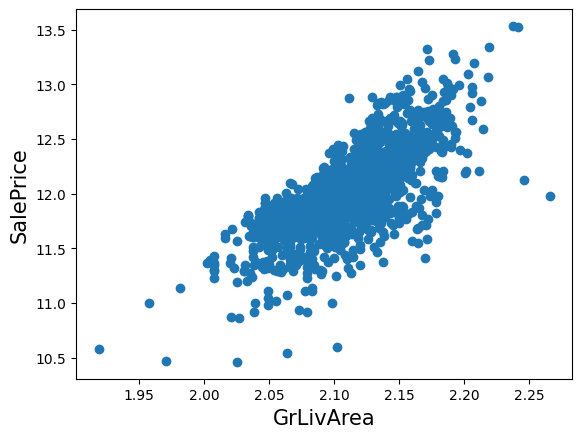

In [47]:
plt.scatter(x = house_df_org['GrLivArea'    ],  y = house_df_org['SalePrice' ])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea',  fontsize=15)
plt.show()

In [48]:
condl  = house_df_ohe['GrLivArea']    > np.log1p(4000)
cond2 = house_df_ohe['SalePrice']    < np.log1p(500000)
outlier_index = house_df_ohe[condl  & cond2].index
print('이상치     레코드    index ：',outlier_index.values)
print('이상치     삭제     전     house_df_ohe shape：',house_df_ohe.shape)
#   DataFrame의      인덱스를    이용해     이상치     레코드    삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치    삭제    후    house_df_ohe shape：/',house_df_ohe.shape)

이상치     레코드    index ： []
이상치     삭제     전     house_df_ohe shape： (1460, 289)
이상치    삭제    후    house_df_ohe shape：/ (1460, 289)


In [50]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',  axis=1,  inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
random_state=156)
ridge_params = {   'alpha' :[0.05, 0.1,  1,  5, 8, 10,  12,  15, 20]  }
lasso_params = {   'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5,10]     }
print_best_params(ridge_reg,  ridge_params)
print_best_params(lasso_reg,  lasso_params)

Ridge 5 CV 시 평균 RMSE 값: 0.139, 최적 alpha 1
Lasso 5 CV 시 평균 RMSE 값: 0.139, 최적 alpha 0.001


LinearRegression 로그 변환된RMSE： 0.13
Ridge 로그 변환된RMSE： 0.137
Lasso 로그 변환된RMSE： 0.133


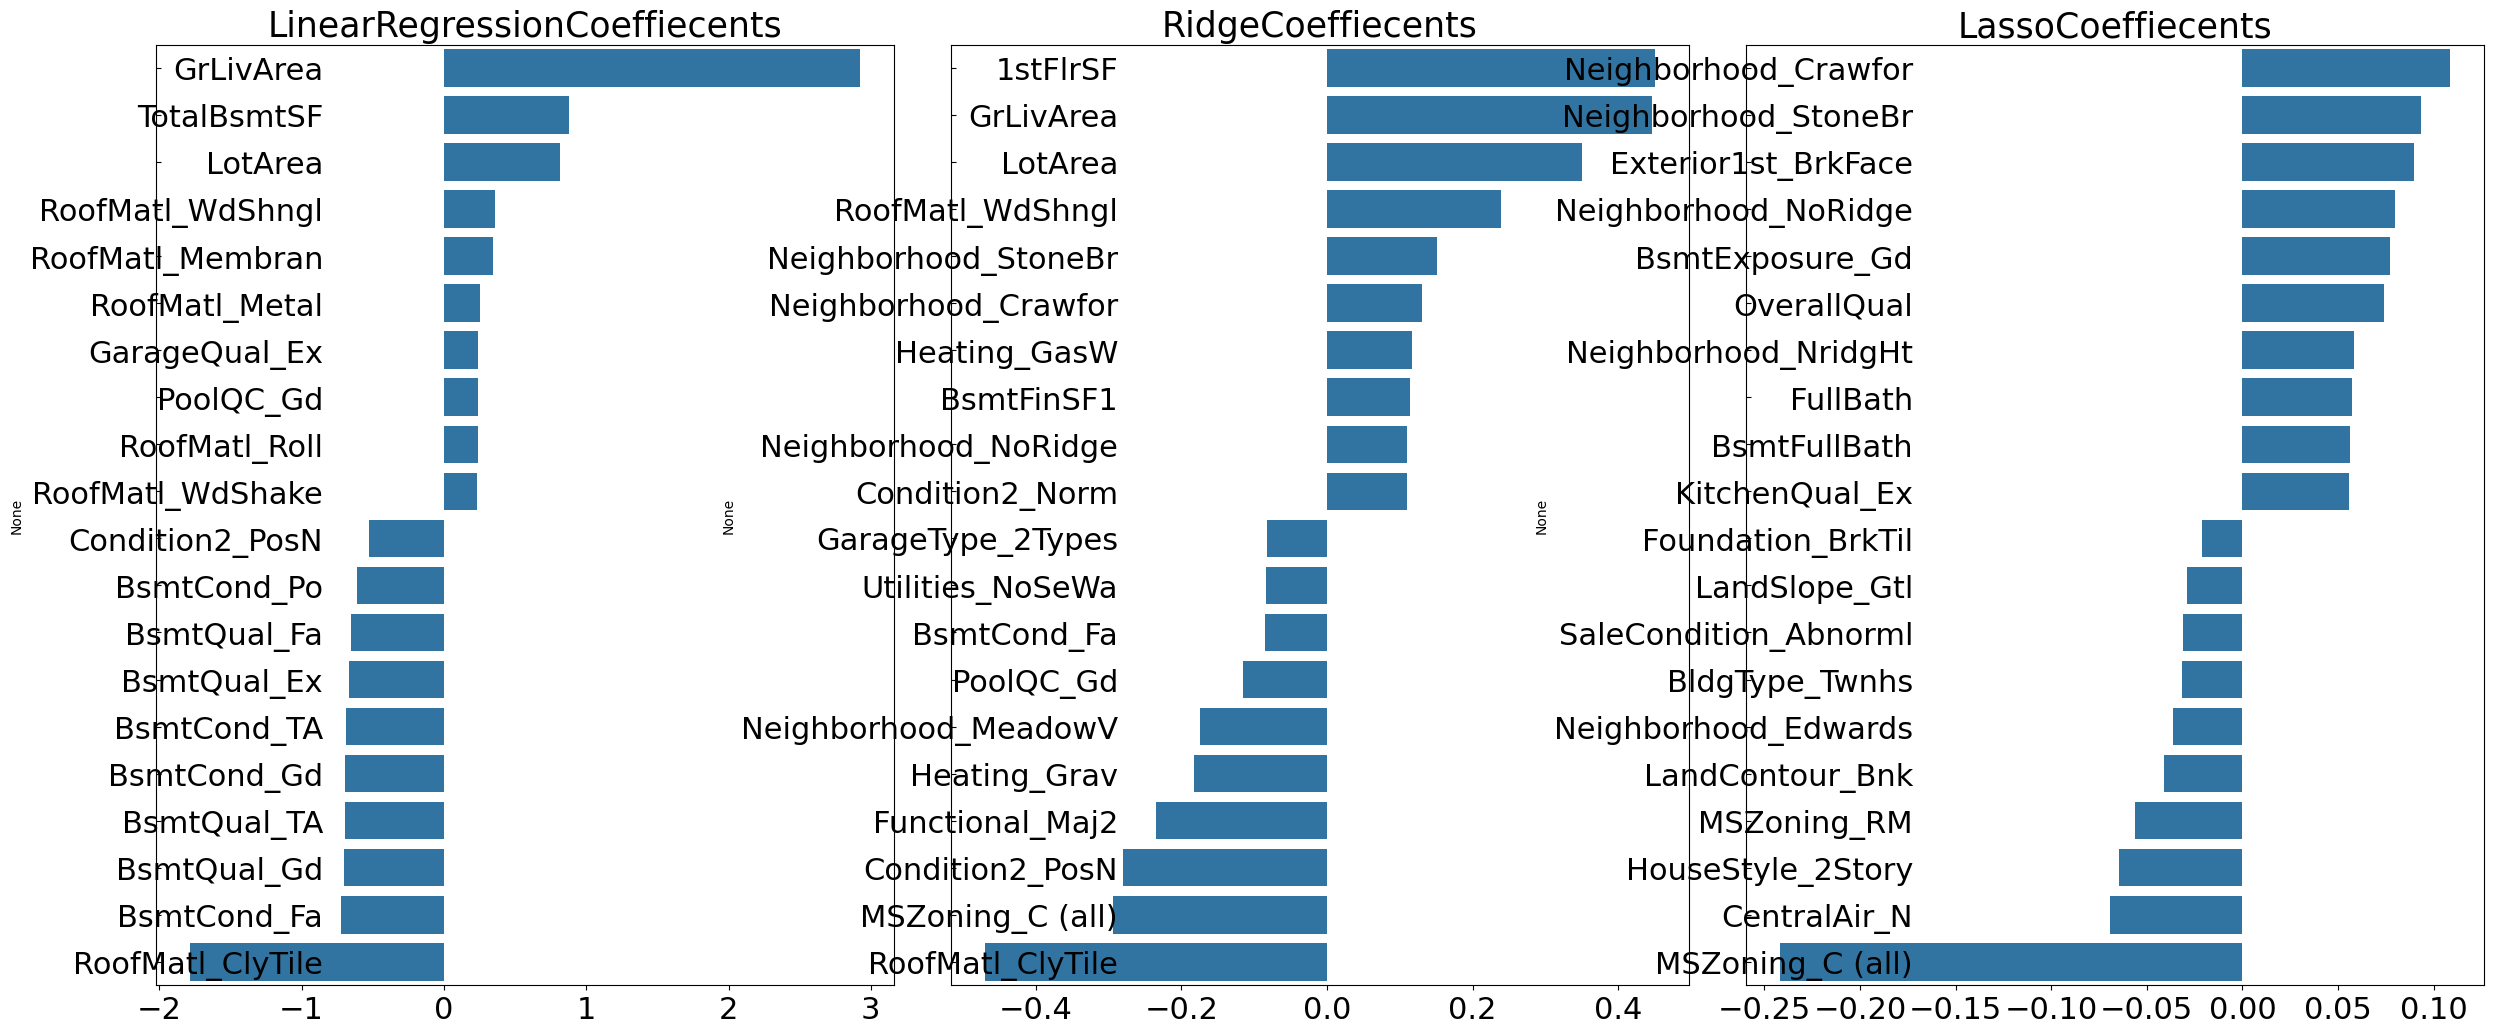

In [51]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,  y_train)
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
#    모든    모델의     RMSE  출력
models = [lr_reg,ridge_reg, lasso_reg]
get_rmses(models)
#    모든    모델의     회귀     계수    시각화
models = [lr_reg,ridge_reg, lasso_reg]
visualize_coefficient(models)

In [60]:
from xgboost import XGBRegressor
xgbjDarams = {'n_estimators' :[ 1000 ]}
xgb_reg = XGBRegressor(n_estimators=1000,  learning_rate=0.05, colsample_bytree= 0.5, subsample=0.8)
print_best_params(xgb_reg,  xgbjDarams)

XGBRegressor 5 CV 시 평균 RMSE 값: 0.126, 최적 n_estimators 1000


In [61]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,  learning_rate=0.05, num_leaves=4,subsample=0.6,colsample_bytree=0.4,reg_lambda=10,n_jobs=-1)
print_best_params(lgbm_reg,  lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3434
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 183
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3445
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 179
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found

In [64]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'.format(key,rmse))

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종    혼합':pred,'Ridge': ridge_pred, 'Lasso': lasso_pred}
get_rmse_pred(preds)

최종    혼합 모델의 RMSE: 0.13295393751846366
Ridge 모델의 RMSE: 0.13676214557691788
Lasso 모델의 RMSE: 0.1331798396018194


In [67]:
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,subsample=0.6,  colsample_bytree=0.4, reg_lambda=10, njobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종   혼합':  pred,'XGBM':xgb_pred, 'LGBM':lgbm_pred}
get_rmse_pred(preds)

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 180
[LightGBM] [Info] Start training from score 12.023289
[LightGBM] [Warning] Unknown parameter: njobs
최종   혼합 모델의 RMSE: 0.12273775815052397
XGBM 모델의 RMSE: 0.12780833024195407
LGBM 모델의 RMSE: 0.12210881884232191


In [68]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n,y_train_n, X_test_n, n_folds ):
  kf = KFold(n_splits=n_folds, shuffle=False)
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')
  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    print('\t 폴드 세트: ',folder_counter,' 시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]
    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    test_pred[:, folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
  return train_fold_pred, test_pred_mean


In [69]:
X_train_n = X_train. values
X_test_n = X_test. values
y_train_n = y_train.values
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_mojdel_lasso = Lasso(alpha = 0.005)

meta_mojdel_lasso.fit(Stack_final_X_train, y_train)
final = meta_mojdel_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('최종 메타 모델의 RMSE: {0:.3f}',rmse)


Ridge model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
Lasso model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
XGBRegressor model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
LGBMRegressor model 시작
	 폴드 세트:  0  시작
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 168
[LightGBM] [Info] Start training from score 12.024507


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
	 폴드 세트:  1  시작
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 168
[LightGBM] [Info] Start training from score 12.023116


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
	 폴드 세트:  2  시작
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3204
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 165
[LightGBM] [Info] Start training from score 12.024756


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
	 폴드 세트:  3  시작
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3216
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 170
[LightGBM] [Info] Start training from score 12.021437


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
	 폴드 세트:  4  시작
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3220
[LightGBM] [Info] Number of data points in the train set: 935, number of used features: 169
[LightGBM] [Info] Start training from score 12.022634
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
최종 메타 모델의 RMSE: {0:.3f} 0.11974686327925607


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
